Neural Networks Assignment

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from tqdm import notebook
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from statistics import mean

random.seed(234558)

num_epochs = 10
input_size = 28*28

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA RTX A4000


## Importing the dataset: Fashion MNIST

In [2]:
## Downloading and loading training and testing data

train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

Getting random (seeded) examples of each class: 
1. t-shirt/top
2. trouser
3. pullover
4. dress
5. coat
6. sandal
7. shirt
8. sneaker
9. bag
10. ankle boot

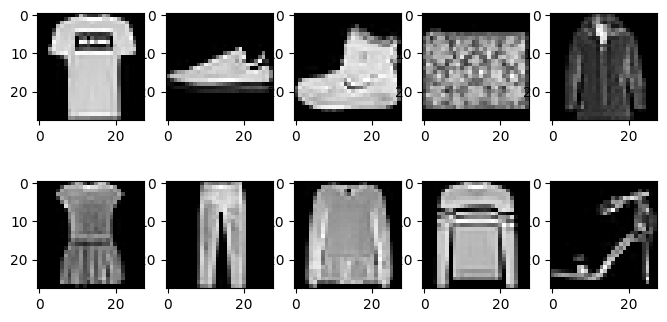

In [3]:
image_list = []
seen_labels = []
for i, (images, labels) in enumerate(train_dataset):
  if len(seen_labels) == 10:
    break
  elif labels not in seen_labels:
    image_list.insert(labels, images[0])
    seen_labels.append(labels)

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i in range(10):
  ax[i % 2, i % 5].imshow(image_list[i], cmap='gray', vmin=0, vmax=1)
plt.show()

To find if our classes are evenly distributed or not, I'll grab the frequency of each. 

This should only take about 10 seconds on colab.

In [4]:
class_frequency = [0,0,0,0,0,0,0,0,0,0]
print(class_frequency)
for i, (images, labels) in notebook.tqdm(enumerate(train_dataset)):
  class_frequency[labels] = class_frequency[labels] + 1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0it [00:00, ?it/s]

In [5]:
print(class_frequency)
print(len(train_dataset))

[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
60000


Our dataset of 60,000 is evenly distributed into 10 lots of 6,000

## Helper Functions

In [6]:
def trainModel(num_epochs, model, data, criterion, optimizer, scheduler):
  model.train() #model in train mode
  epochs = notebook.tqdm(range(num_epochs))

  loss_list = []

  for epoch in epochs:
    total_loss = 0
    for i, (images, labels) in enumerate(data):
      # move tensors to device (CPU or GPU)
      images = images.to(device)
      labels = labels.to(device)

      #forward pass
      predictions = model(images)
      loss = criterion(predictions, labels)

      #backward pass, optimise
      loss.backward() #backprop the loss
      total_loss += loss.item()
      
      optimizer.step()
      optimizer.zero_grad()

      if (i + 1) % 10 == 0: #update progress bar every 10 batches
        epochs.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{len(data)}], Loss: {loss.item():.4f}")
    loss_list.append(total_loss) #may have to make a running loss
    scheduler.step() #np.mean(loss_list)
  return loss_list

In [7]:
def testModel(model, data):
  model.eval() # model in evaluation mode
  
  pred_list = []
  accuracy_list = []

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in notebook.tqdm(data):
      images = images.to(device)
      labels = labels.to(device)

      predictions = model(images)
      _, predictions = torch.max(predictions.data, 1)
      total += labels.size(0)
      correct += (predictions == labels).sum().item()
      
      pred_list.append(predictions.cpu())
      accuracy_list.append((predictions == labels).sum().item() / labels.size(0))

  print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
  return pred_list, accuracy_list

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
def plot_curves(loss, accuracy):
  # Loss Curve
  plt.subplot(2, 1, 1)
  plt.plot(loss, color='b', label='loss')

  plt.plot(moving_average(loss, 10), color='g', label='trend')
  plt.ylim((0, 300))
  plt.xlim((0, num_epochs-1))
  plt.title("Loss")

  # Accuracy Curve
  plt.subplot(2, 1, 2)
  plt.plot(accuracy, color='b', label='accuracy')
  plt.plot(moving_average(accuracy, 10), color='g', label='trend')
  plt.ylim((0.5, 1))
  plt.title("Accuracy")

  plt.tight_layout()
  plt.show()

In [10]:
def plot_confusion_matrix(cm):
  ConfusionMatrixDisplay(cm).plot()

In [11]:
def modelMetrics(predictions, labels, running_loss, running_accuracy):
  if predictions[0].is_cuda:  # if running on a GPU, convert back to regular CPU tensors so that sklearn can parse 
    predictions = [pred.cpu() for pred in predictions]
  cm = confusion_matrix(labels, predictions)
  
  plot_curves(running_loss, running_accuracy)
  #plot_confusion_matrix(cm) #not really that useful comparatively, since it shows a 10x10 grid

  return cm

In [12]:
def ignore_batches(raw_predictions):
  all_predictions = [item for batch in raw_predictions for item in batch]
  if all_predictions[0].is_cuda:
    all_predictions = [pred.cpu() for pred in all_predictions] 
  return all_predictions

In [13]:
def run_experiment(lr=0.001, optimiser='adam', dropout=0.0, lr_momentum=0, 
                   activation_func=nn.ReLU(), batch_size=32, hidden_width=500,
                   hidden_depth=2, input_size=input_size, scheduler=''
                   ):
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
  model = BaseMLP(
      input_size,
      hidden_width,
      hidden_depth,
      activation_func,
      scheduler,
      dropout=dropout
      ).to(device)

  if optimiser.lower() == 'adam':
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  elif optimiser.lower() == 'sgd':
    optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=lr_momentum)
  elif optimiser.lower() == 'rmsprop':
    optimiser = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=lr_momentum)
  elif optimiser.lower() == 'sparseadam':
    optimiser = torch.optim.SparseAdam(model.parameters(), lr=lr, momentum=lr_momentum)
  elif optimiser.lower() == 'rprop':
    optimiser = torch.optim.Rprop(model.paramters(), lr=lr, momentum=lr_momentum)

  
  loss = trainModel(num_epochs, model, train_loader, nn.CrossEntropyLoss(), optimiser)
  predictions, accuracy = testModel(model, test_loader)

  modelMetrics(ignore_batches(predictions), test_dataset.targets, loss, accuracy)
  return model

In [14]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
linewidth = 1

def plotSeriesMetrics(losses, accuracies):
  # Loss Curve
  plt.subplot(2, 1, 1)
  zorder = 100
  plt.plot(np.mean(losses, axis=0), 'k--', label='Trend', linewidth=linewidth, zorder=zorder)
  for i in range(len(losses)):
    plt.plot(losses[i], color=colors[i], label='Loss of #' + str(i+1), linewidth=linewidth, zorder=zorder)
    zorder -= 5
  
  plt.ylim((0, 300))
  plt.xlim((0, num_epochs-1))
  plt.legend()
  plt.title("Loss")

  # Accuracy Curve
  plt.subplot(2, 1, 2)
  zorder = 100
  plt.plot(np.mean(accuracies, axis=0), 'k--', label='Trend', linewidth=linewidth, zorder=zorder)
  for i in range(len(accuracies)):
    plt.plot(accuracies[i], color=colors[i], label='Accuracy of #' + str(i+1), linewidth=linewidth, zorder=zorder)
    zorder -= 5
  
  plt.ylim((0.5, 1))
  plt.legend()
  plt.title("Accuracy")

  plt.tight_layout()
  plt.show()

In [15]:
def seriesMetrics(pred_list, labels, loss_list, accuracy_list):
  confusion_matrices = []
  for i in range(len(pred_list)):
    pred = pred_list[i]
    loss = loss_list[i]
    acc = accuracy_list[i]
    
    if pred[0].is_cuda:  # if running on a GPU, convert back to regular CPU tensors so that sklearn can parse 
      pred = [pr.cpu() for pr in pred]
    
    #confusion_matrices.append(confusion_matrix(labels, pred))
    #plot_confusion_matrix(cm) #not really that useful comparatively, since it shows a 10x10 grid
  
  plotSeriesMetrics(loss_list, accuracy_list)
  return confusion_matrices

In [16]:
def run_series(
    lr_start=0.001, lr_momentum=0.0, lr_scheduler='step', lr_scheduler_gamma=0.1, lr_scheduler_var=0.1,
    activation_function=nn.ReLU(), optimiser_name='adam',
    batch_size = 100, hidden_width=500, hidden_depth=2, dropout=0.0, input_size=input_size, repeats=3
    ):
    losses = []
    accuracies = []
    predictions = []
    models = []
    for i in range(repeats):
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)
                                            
        model = BaseMLP(
            input_size,
            hidden_width,
            hidden_depth,
            activation_function,
            dropout=dropout
        ).to(device)

        if optimiser_name == 'adam':
            optimiser = torch.optim.Adam(model.parameters(), lr=lr_start)
        elif optimiser_name == 'sgd':
            optimiser = torch.optim.SGD(model.parameters(), lr=lr_start, momentum=lr_momentum)
        elif optimiser_name == 'rmsprop':
            optimiser = torch.optim.RMSprop(model.parameters(), lr=lr_start, momentum=lr_momentum)
        elif optimiser_name == 'sparseadam':
            optimiser = torch.optim.SparseAdam(model.parameters(), lr=lr_start, momentum=lr_momentum)
        elif optimiser_name == 'rprop':
            optimiser = torch.optim.Rprop(model.parameters(), lr=lr_start, momentum=lr_momentum)

        if lr_scheduler == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimiser, gamma=lr_scheduler_gamma, step_size=lr_scheduler_var)
        elif lr_scheduler == 'multistep':
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, gamma=lr_scheduler_gamma, milestones=lr_scheduler_var)
        elif lr_scheduler ==  'exponential':
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=lr_scheduler_gamma, last_epoch=num_epochs-1)
        elif lr_scheduler == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=lr_scheduler_var)
        elif lr_scheduler == 'lambda':
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimiser, lr_lambda=lr_scheduler_var, last_epoch=num_epochs-1)


        losses.append(trainModel(num_epochs, model, train_loader, nn.CrossEntropyLoss(), optimiser, scheduler))
        p, a = testModel(model, test_loader)
        predictions.append(p)
        accuracies.append(a)
        models.append(model)
    seriesMetrics(predictions, test_dataset.targets, losses, accuracies)
    return models, predictions, losses, accuracies
   
    

## Base Fully-connected Neural Net

In [17]:
class BaseMLP(nn.Module):
  def __init__(self, input_size, hidden_width, hidden_depth, activation_func,
               dropout=0, num_classes=10):
    super().__init__()

    operations = [
        nn.Linear(input_size, hidden_width), #input layer -> hidden layer
        nn.BatchNorm1d(hidden_width),
        nn.Dropout(dropout),
        activation_func
    ]

    if (hidden_depth > 2): #shrink_width used to scale down the width (number of nodes) per layer
      shrink_width = int(hidden_width / (hidden_depth - 1))

    for i in range(2, hidden_depth):
      next_width = int(hidden_width - shrink_width)
      operations.extend([
          nn.Linear(hidden_width, next_width), #hidden layer i -> hidden layer i + 1
          nn.BatchNorm1d(next_width),
          nn.Dropout(dropout),
          activation_func
      ])
      hidden_width -= next_width

    operations.append(nn.Linear(hidden_width, num_classes)) #hidden layer -> output layer

    self.sequence = nn.Sequential(*operations)
  
  def forward(self, x):
    out = self.sequence(x.reshape(-1, 28 * 28))
    return out

Baseline performance

In [18]:
baseline_learning_rate = 0.001
baseline_batch_size = 100
baseline_dropout = 0.0
baseline_hidden_width = 100
baseline_hidden_depth = 2
baseline_activation_func = nn.ReLU()

# Baseline Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=baseline_batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=baseline_batch_size, 
                                          shuffle=False)

baseline_model = BaseMLP(input_size, baseline_hidden_width, 
                         baseline_hidden_depth, baseline_activation_func, 
                         baseline_dropout).to(device)


baseline_optimiser = torch.optim.Adam(baseline_model.parameters(), lr=baseline_learning_rate)

baseline_lr_scheduler = torch.optim.lr_scheduler.StepLR(baseline_optimiser, step_size=10)

baseline_loss = trainModel(num_epochs, baseline_model, train_loader, nn.CrossEntropyLoss(), baseline_optimiser, scheduler=baseline_lr_scheduler)

baseline_predictions, baseline_accuracy = testModel(baseline_model, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.29%


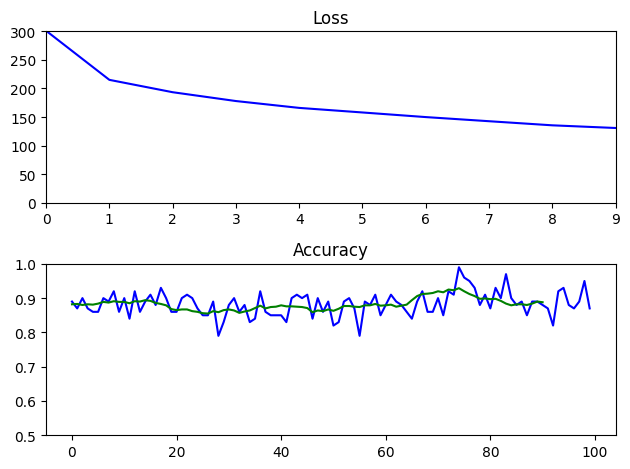

In [19]:
#Plot/Print Metrics
modelMetrics(ignore_batches(baseline_predictions), test_dataset.targets, baseline_loss, baseline_accuracy)
pass #avoid auto-print

## Learning Rate
Optimum constant LR = 0.001

In [20]:
lrpoint00001_models, lrpoint00001_preds, lrpoint00001_losses, lrpoint00001_accuracies = run_series(lr_start=0.00001)

TypeError: __init__() got multiple values for argument 'dropout'

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 86.98%


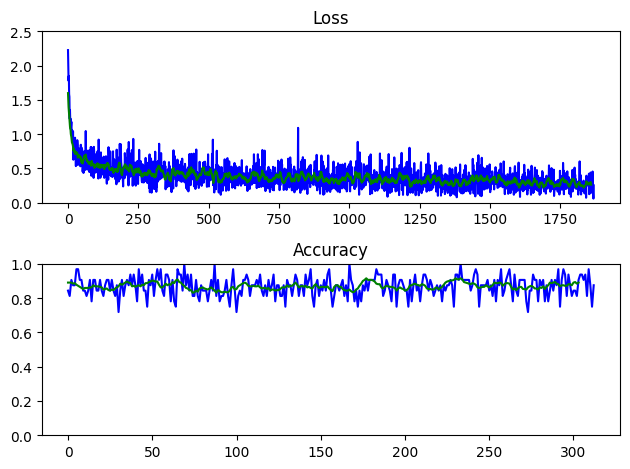

In [ ]:
lr_point0001 = run_experiment(lr=0.0001)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.39%


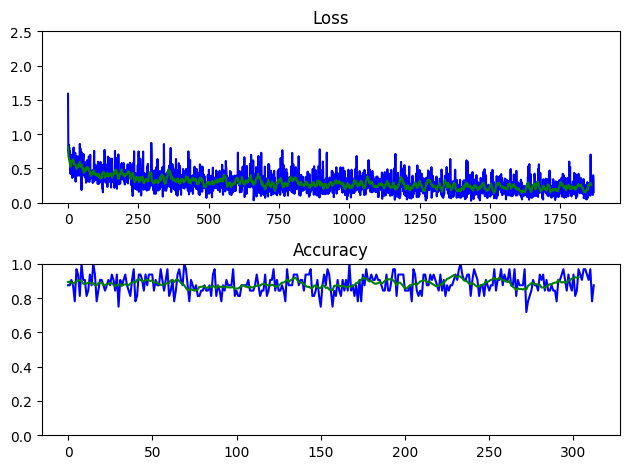

In [ ]:
lr_point001 = run_experiment(lr=0.001)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83.57%


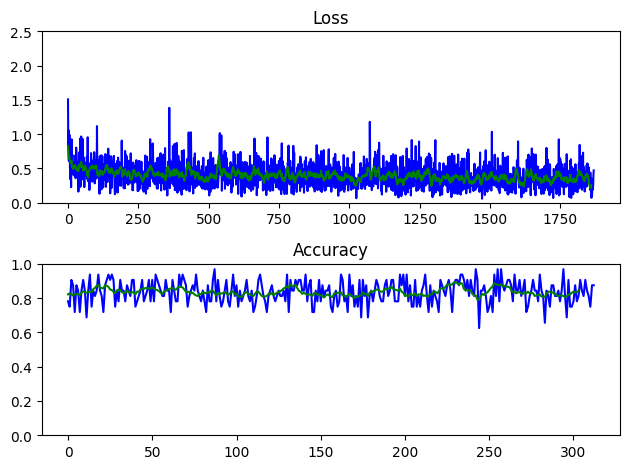

In [ ]:
lr_point01 = run_experiment(lr=0.01)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 21.78%


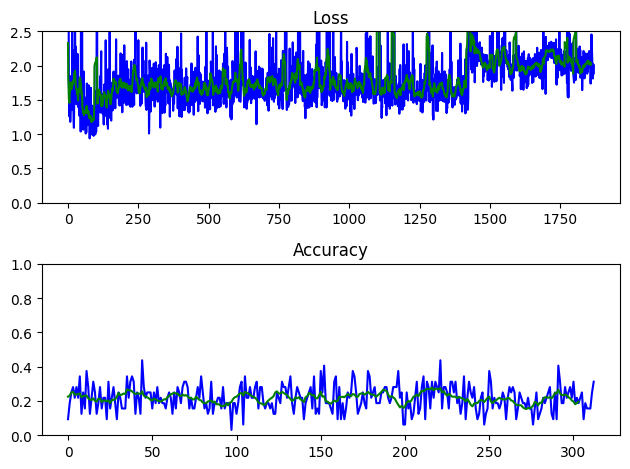

In [ ]:
lr_point1 = run_experiment(lr=0.1)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 10.0%


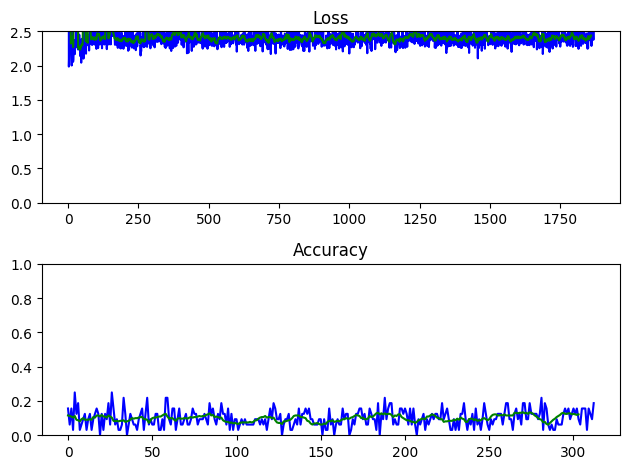

In [ ]:
lr_1 = run_experiment(lr=1)
pass

It appears my testing range goes too high, and such high learning rates likely cause overfitting resulting in shockingly bad accuracy.

From the testing accuracies, it looks like the ideal learning rate is somewhere around 0.001. So I'll investigate a tighter range around this value a bit more

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.95%


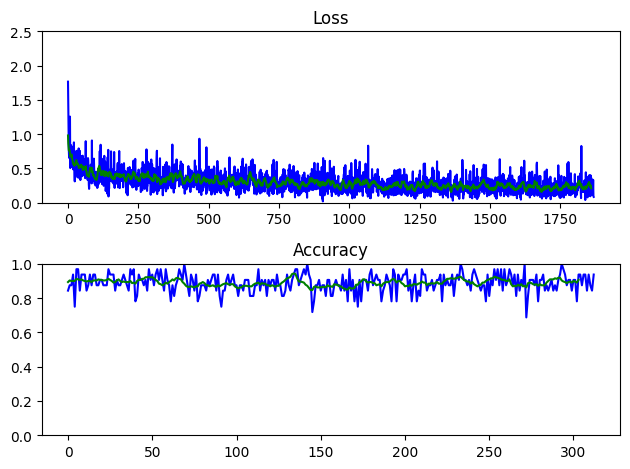

In [ ]:
lr_point0005 = run_experiment(lr=0.0005) #1/2 of 0.001
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.95%


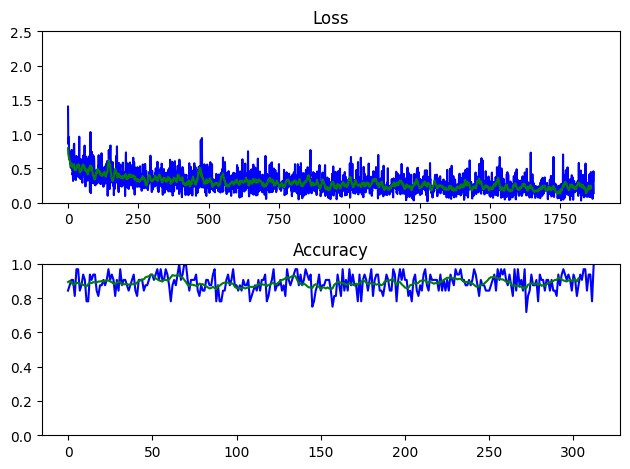

In [ ]:
lr_point00075 = run_experiment(lr=0.00075) #3/4 of 0.001
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.48%


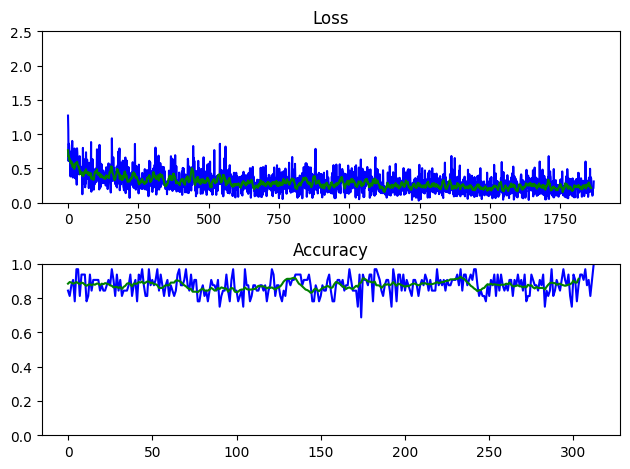

In [ ]:
lr_point0015 = run_experiment(lr=0.0015) #1.5x 0.001
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.05%


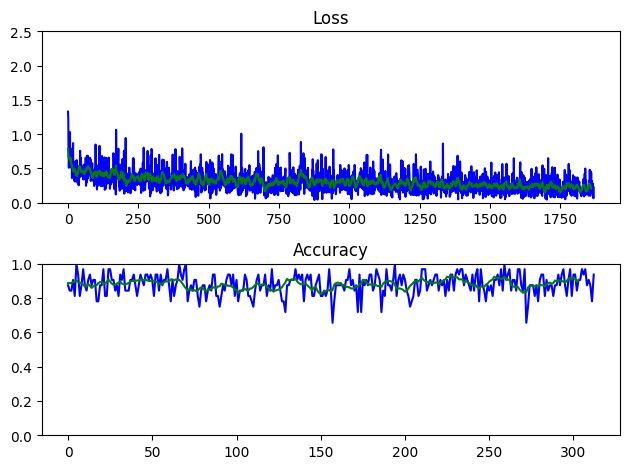

In [ ]:
lr_point002 = run_experiment(lr=0.002) #2x 0.001
pass

Since the difference in these values is within a margin of error, I will continue with the original best value 0.001

## Learning Rate Scheduler


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84.27%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84.09%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84.09%


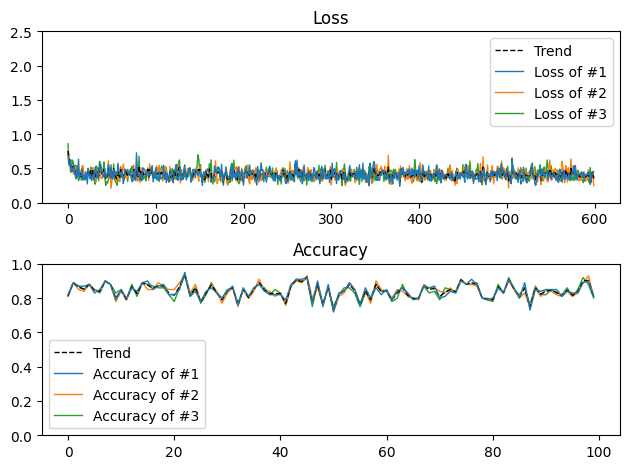

In [ ]:
#StepLR - the most basic scheduler
steplr_models, steplr_preds, steplr_losses, steplr_accuracies = run_series(lr_scheduler='step', lr_scheduler_var=100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.32%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.34%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.21%


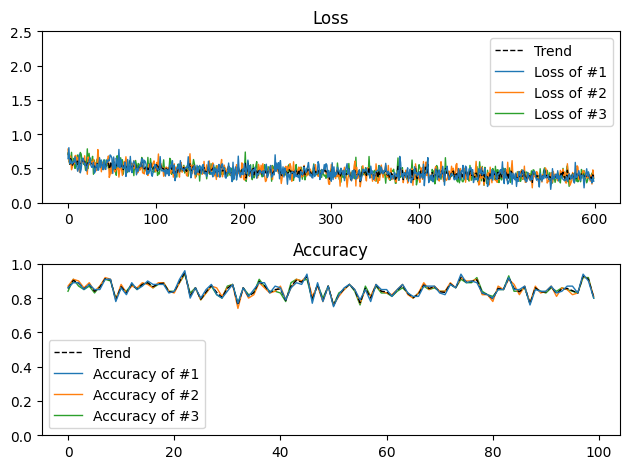

In [ ]:
#MultiStepLR - similar to steplr
multisteplr_models, multisteplr_preds, multisteplr_losses, multisteplr_accuracies = run_series(lr_scheduler='multistep', lr_scheduler_var=[20, 50])

In [ ]:
#ExponentialLR
exponentiallr_models, exponentiallr_preds, exponentiallr_losses, exponentiallr_accuracies = run_series(lr_scheduler='exponential', lr_scheduler_gamma=0.3)

KeyError: "param 'initial_lr' is not specified in param_groups[0] when resuming an optimizer"

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84.89%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.13%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84.82%


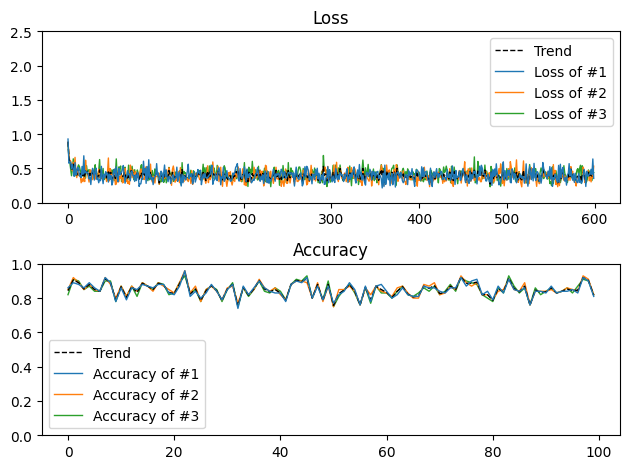

In [ ]:
#ReduceLROnPlateau
rlrop_models, rlrop_preds, rlrop_losses, rlrop_accuracies = run_series(lr_scheduler='reduce_on_plateau', lr_scheduler_var=0.5)
#TODO: needs validation loss

In [ ]:
#LambdaLR (decide on a function of your own?)

## Activation (Loss) Function

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.27%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.58%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.53%


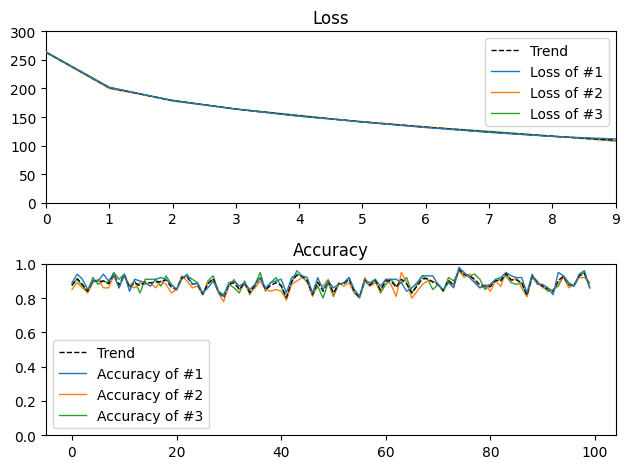

In [ ]:
relu_models, relu_preds, relu_losses, relu_accuracies = run_series(activation_function=nn.ReLU())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.44%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.4%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.99%


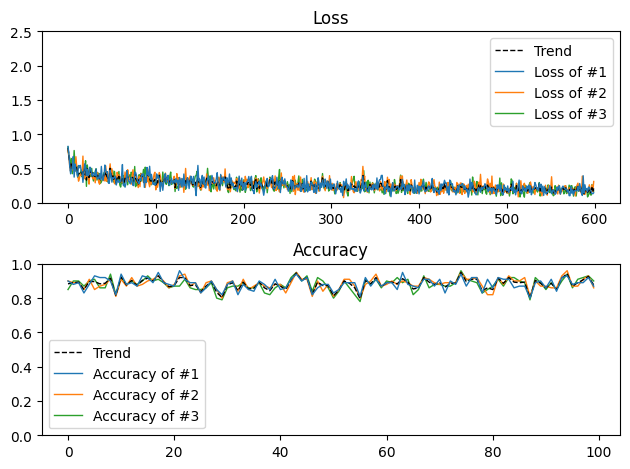

In [ ]:
leakyrelu_models, leakyrelu_preds, leakyrelu_losses, leakyrelu_accuracies = run_series(activation_function=nn.LeakyReLU())

In [ ]:
sigmoid_models, sigmoid_preds, sigmoid_losses, sigmoid_accuracies = run_series(activation_function=nn.Sigmoid())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.92%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.28%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.77%


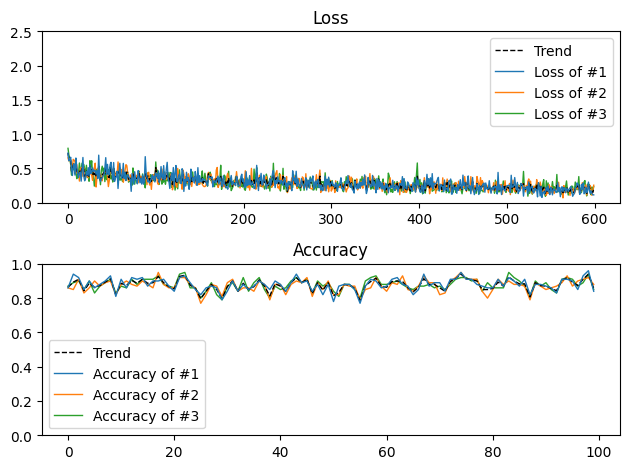

In [ ]:
tanh_models, tanh_preds, tanh_losses, tanh_accuracies = run_series(activation_function=nn.Tanh())

## Width
Optimum: N/A as it doesn't seem to matter with this problem and my auto-downscaling of the width of each layer
Bearing in mind the input size is 784 (28*28 pixels), and that I automatically scale down each layer

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.31%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.29%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.07%


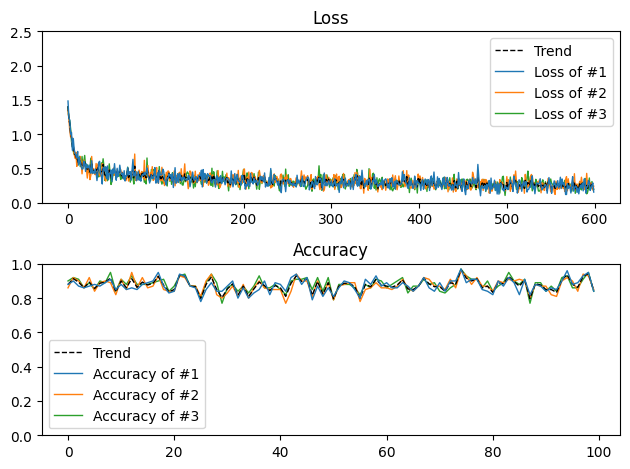

In [ ]:
w50_models, w50_preds, w50_losses, w50_accuracies = run_series(hidden_width=50)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 86.13%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.49%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 86.74%


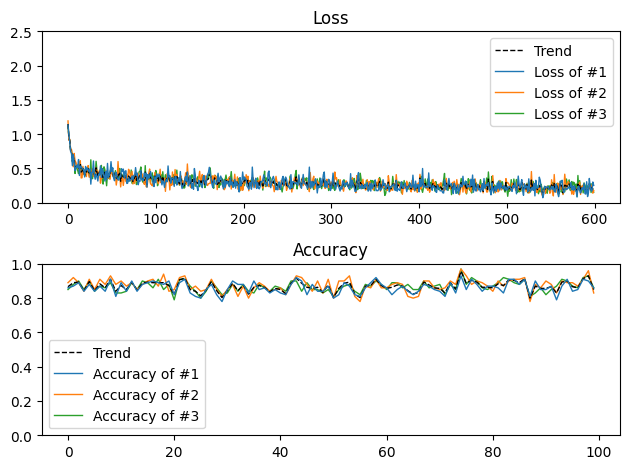

In [ ]:
w100_models, w100_preds, w100_losses, w100_accuracies = run_series(hidden_width=100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.29%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 86.96%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.0%


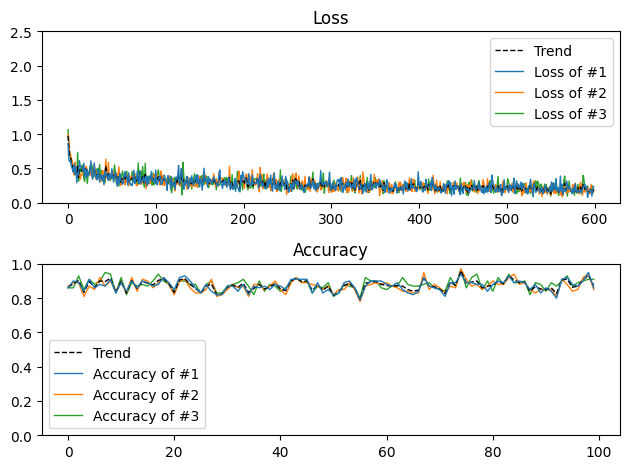

In [ ]:
w200_models, w200_preds, w200_losses, w200_accuracies = run_series(hidden_width=200)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.78%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.48%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.15%


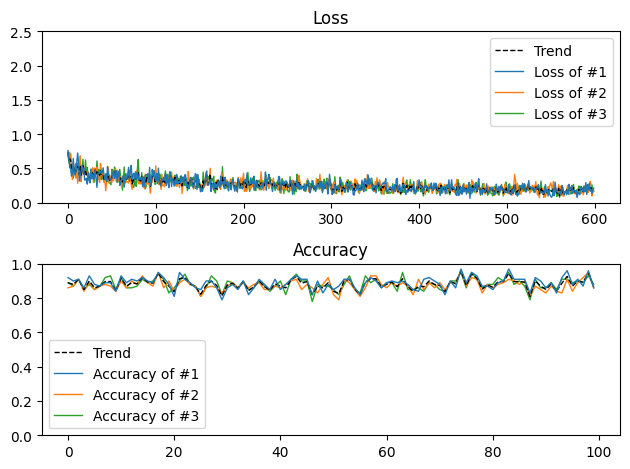

In [ ]:
w500_models, w500_preds, w500_losses, w500_accuracies = run_series(hidden_width=500)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.11%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.01%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.24%


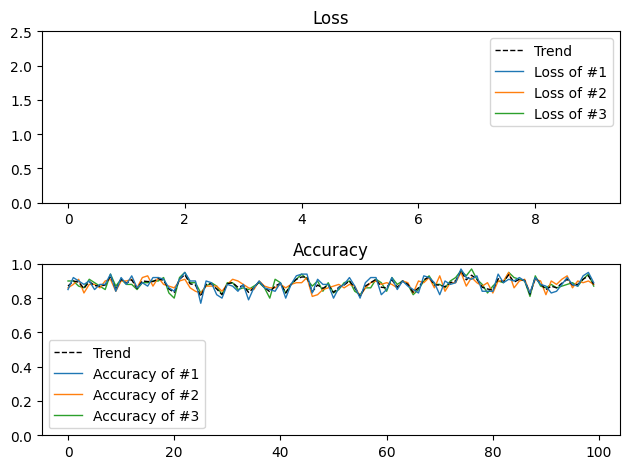

In [ ]:
w1000_models, w1000_preds, w1000_losses, w1000_accuracies = run_series(hidden_width=1000)

The optimum seems to rest somewhere between 500 and 1000.

While the change is fairly small, it would appear that the best we can do is slightly exceed the width of the input (28*28=784): we see 784 wide and 800 wide hidden layer networks perform better, but what performs best is in the neighbourhood of 900 nodes wide.

## Depth
Optimum: 4-8

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.31%


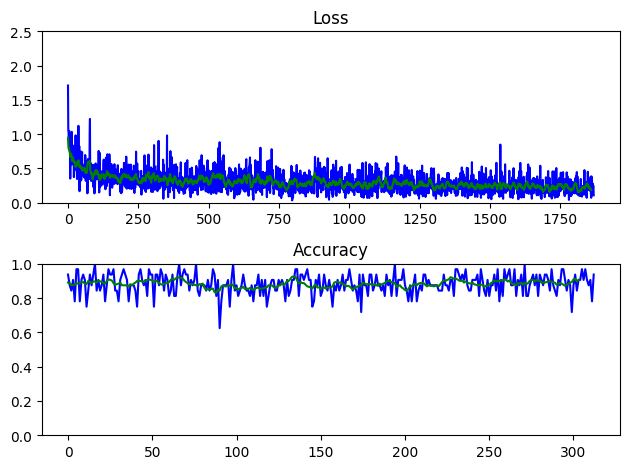

In [ ]:
#4 layers
d4_models, d4_preds, d4_losses, d4_accuracies = run_series(hidden_depth=4)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.79%


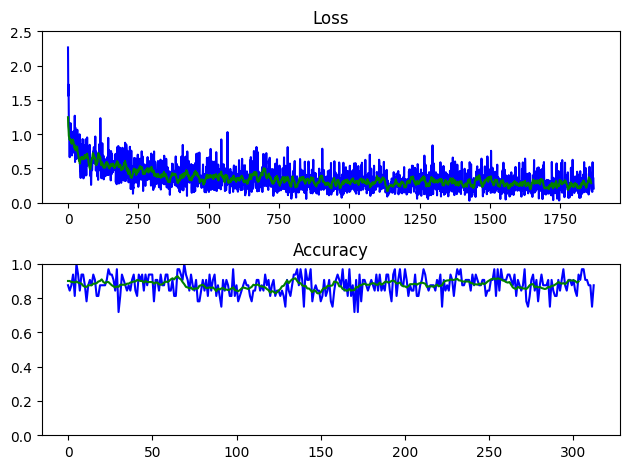

In [ ]:
#8 layers
d8_models, d8_preds, d8_losses, d8_accuracies = run_series(hidden_depth=8)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 35.28%


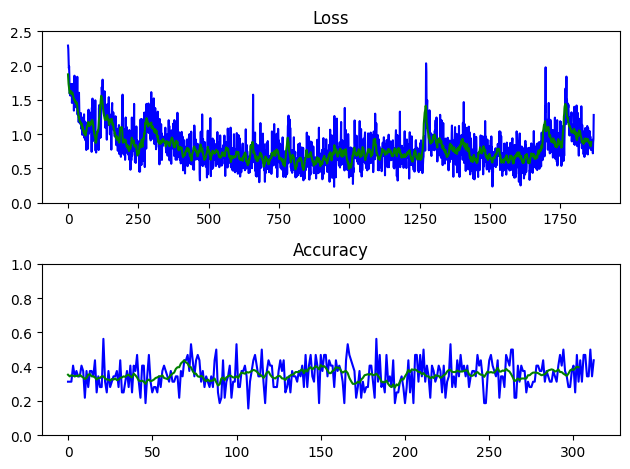

In [ ]:
#16 layers
d16_models, d16_preds, d16_losses, d16_accuracies = run_series(hidden_depth=16)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 10.0%


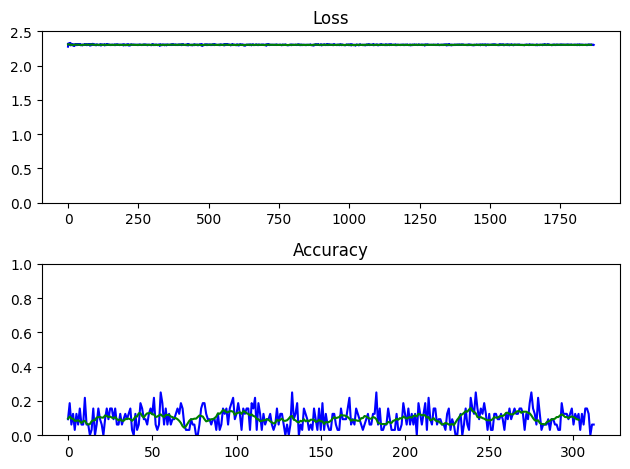

In [ ]:
#32 layers
d32_models, d32_preds, d32_losses, d32_accuracies = run_series(hidden_depth=32)
pass

Diminishing returns set in between 4 and 8 layers deep.

## Batch Size

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.57%


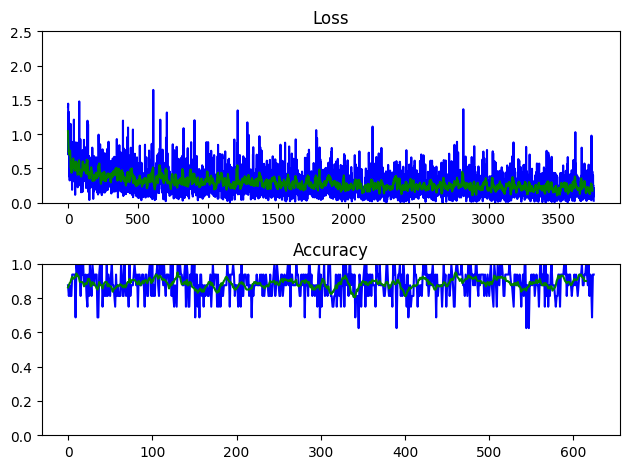

In [ ]:
bs16_models, bs16_preds, bs16_losses, bs16_accuracies = run_series(batch_size=16)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.68%


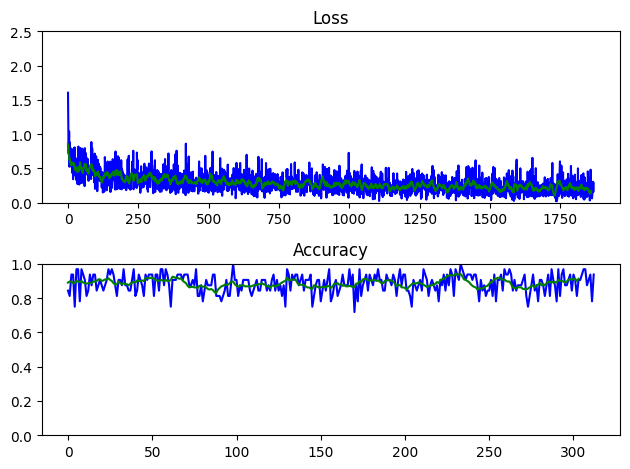

In [ ]:
bs32_models, bs32_preds, bs32_losses, bs32_accuracies = run_series(batch_size=32)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.98%


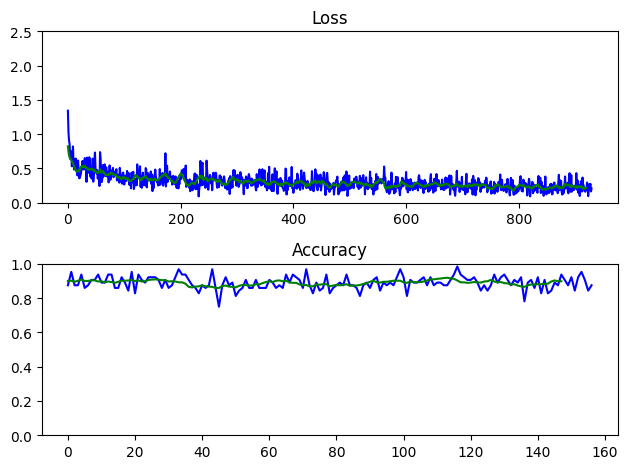

In [ ]:
bs64_models, bs64_preds, bs64_losses, bs64_accuracies = run_series(batch_size=64)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.84%


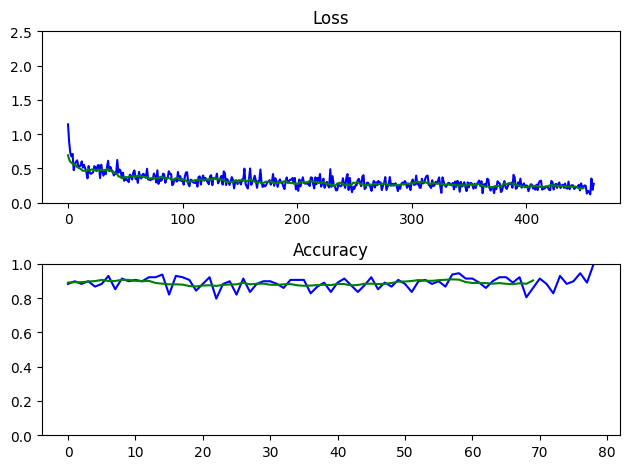

In [ ]:
bs128_models, bs128_preds, bs128_losses, bs128_accuracies = run_series(batch_size=128)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.59%


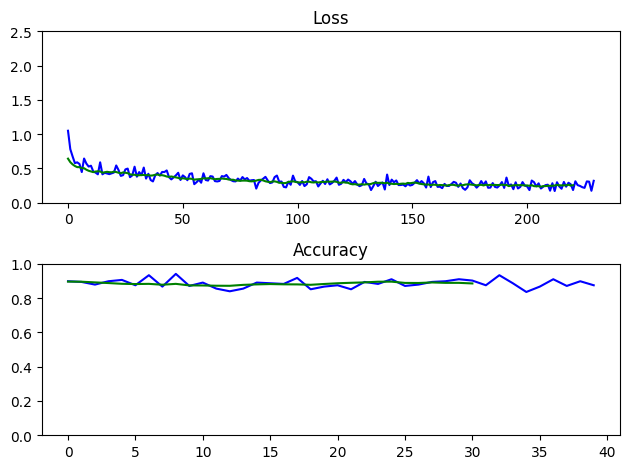

In [ ]:
bs256_models, bs256_preds, bs256_losses, bs256_accuracies = run_series(batch_size=256)

**Findings**

The trend I've found is that the greater the batch size, the faster and smoother the loss decreases, but this comes with diminishing returns

## Dropout


TODO: Re-do this with wider/deeper models as it works best with them


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.78%


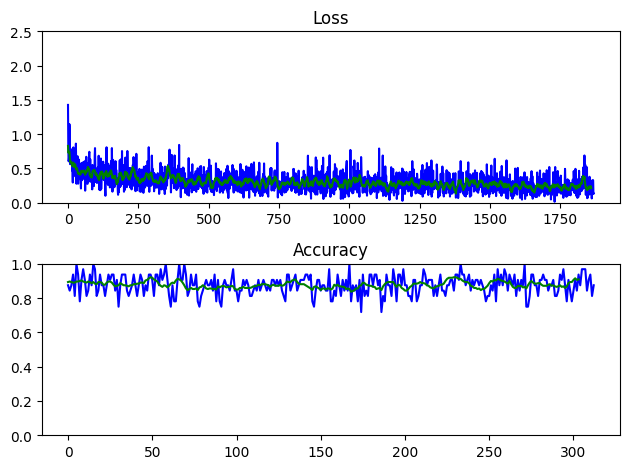

In [ ]:
dopoint1_models, dopoint1_preds, dopoint1_losses, dopoint1_accuracies = run_series(dropout=0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.97%


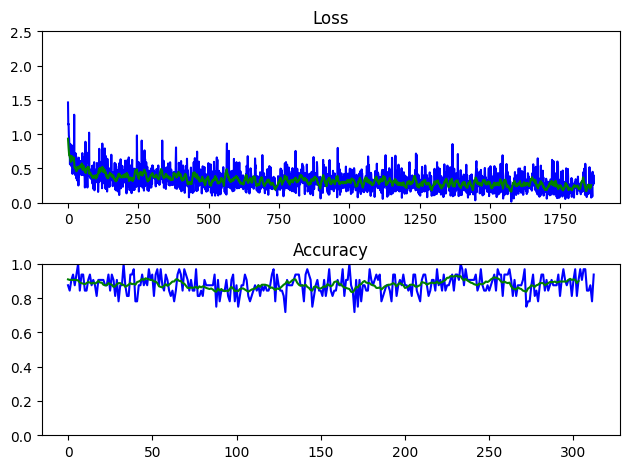

In [ ]:
dopoint2_models, dopoint2_preds, dopoint2_losses, dopoint2_accuracies = run_series(dropout=0.2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.72%


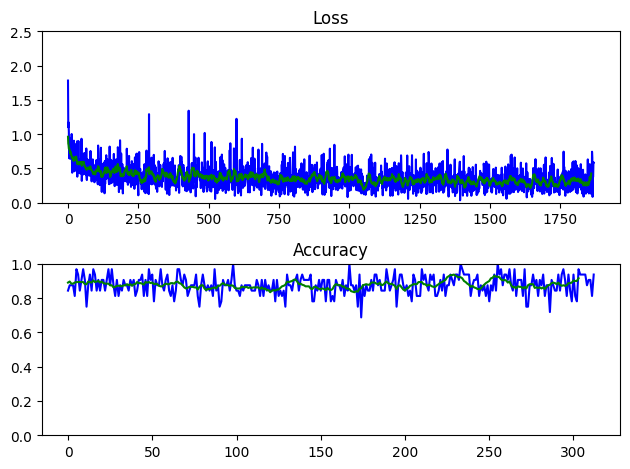

In [ ]:
dopoint4_models, dopoint4_preds, dopoint4_losses, dopoint4_accuracies = run_series(dropout=0.4)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 86.42%


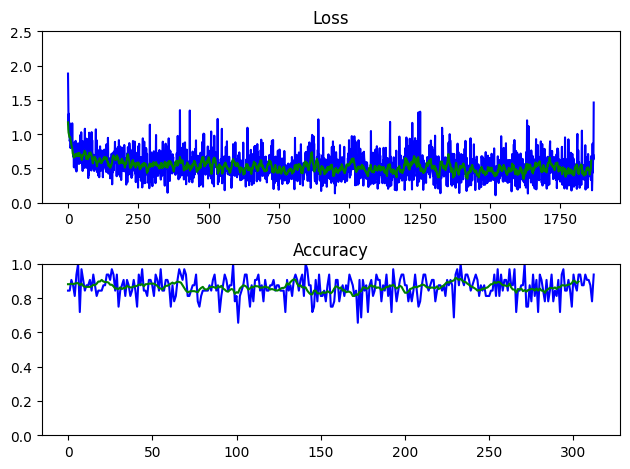

In [ ]:
dopoint8_models, dopoint8_preds, dopoint8_losses, dopoint8_accuracies = run_series(dropout=0.8)

# Final Model

put together and refine your findings from before

todo: use train/validation split
random search

In [ ]:
#train / validation split
#random_generator = torch.Generator().manual_seed(234558)
#train, val = torch.utils.data.random_split(train_data, [7, 3], generator=random_generator)